In [1]:
import numpy as np
import pandas as pd
import pickle
import pathlib

from sklearn.model_selection import train_test_split

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

In [2]:
def save_model(clf, name, path='./models/04_Jass_sklearn/', overwrite=False):
    _file = pathlib.Path(path+name)
    if _file.exists():
        if overwrite:
                _file.unlink()
        else:
            print('%s file already exists' % (str(path+name)))
            return
    with open(path+name, 'xb') as f:
        pickle.dump(clf, f)
    
def load_model(name, path='./models/04_Jass_sklearn/'):
    return pickle.load(open(path+name, 'rb'))

In [3]:
import itertools
datafile = 'data/jass/rnd_01.csv'
col_names = [a+str(b) for (a,b) in itertools.product([farbe for farbe in 'HKSE'], [bild for bild in range(9)])]+["Geschoben", "Player", "Aktion"]
data = pd.read_csv(datafile, header=None, names=col_names)

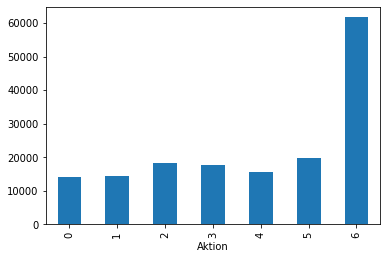

In [5]:
# Plot overall distribution of targets (Aktion)
data.groupby('Aktion').size().plot(kind='bar')

Aktion = 6 might be "Schieben". This might be a problem in one-vs-rest/one-vs-one classificatoin

## One vs. One classification on targets 0 and 1

In [6]:
# select subset of data
target_classes = [0,1]
zeroone = data[data['Aktion'].isin(target_classes)]
zeroone = zeroone.drop(columns='Player')
X = zeroone.loc[:,'H0':'Geschoben']
y = zeroone.loc[:,'Aktion']

# make sure targets are binary (required by GPC implementation of sklearn)
y = y.isin(target_classes[0:1]) # first class = 1, second = 0

In [7]:
# Analyize set. Are there any equal x with other y?
n = (zeroone.groupby(by=list(X.columns)).Aktion.nunique() > 1).sum() / 2
print('Same input but different output: %d (%.2f%%)' % (n, n/X.shape[0]))

Same input but different output: 0 (0.00%)


In [9]:
train_size = 1000
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size,test_size=10000, random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))
kernel = 1.0*RBF()
clf1 = GaussianProcessClassifier(kernel, n_restarts_optimizer=3, random_state=23)
%time _ = clf1.fit(X_train, y_train)
#save_model(clf1, 'model1')
%time score = clf1.score(X_test, y_test)
print('Accuracy: %.3f' % score)

Train: 1000, Test: 10000
CPU times: user 1min 13s, sys: 1min 1s, total: 2min 14s
Wall time: 22.7 s
CPU times: user 570 ms, sys: 490 ms, total: 1.06 s
Wall time: 450 ms
Accuracy: 0.961


In [10]:
train_size = 2000
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size,test_size=10000, random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))
kernel = 1.0*RBF()
clf2 = GaussianProcessClassifier(kernel, n_restarts_optimizer=3, random_state=23)
%time _ = clf2.fit(X_train, y_train)
#save_model(clf2, 'model2')
%time score = clf2.score(X_test, y_test)
print('Accuracy: %.3f' % score)

Train: 2000, Test: 10000
CPU times: user 9min 1s, sys: 5min 25s, total: 14min 26s
Wall time: 2min 42s
CPU times: user 1.25 s, sys: 460 ms, total: 1.71 s
Wall time: 1.02 s
Accuracy: 0.962


In [11]:
train_size = 4000
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size,test_size=10000, random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))
kernel = 1.0*RBF()
clf2_4 = GaussianProcessClassifier(kernel, n_restarts_optimizer=3, random_state=23)
%time _ = clf2_4.fit(X_train, y_train)
save_model(clf2_4, 'model2')
%time score = clf2_4.score(X_test, y_test)
print('Accuracy: %.3f' % score)

Train: 4000, Test: 10000
CPU times: user 46min 47s, sys: 11min 13s, total: 58min
Wall time: 12min 30s
./models/04_Jass_sklearn/model2 file already exists
CPU times: user 1.87 s, sys: 420 ms, total: 2.29 s
Wall time: 1.72 s
Accuracy: 0.964


## Multiclass classification: One vs. Rest

In [9]:
# select subset of data
allclasses = data.drop(columns='Player')
X = allclasses.loc[:,'H0':'Geschoben']
y = allclasses.loc[:,'Aktion']

In [10]:
# Analyize set. Are there any equal x with other y?
n = (allclasses.groupby(by=list(X.columns)).Aktion.nunique() > 1).sum() / 2
print('Same input but different output: %d (%.5f%%)' % (n, n/X.shape[0]))

Same input but different output: 24 (0.00015%)


In [11]:
train_size = 1000
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size, test_size=10000, random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))
kernel = 1.0*RBF()
clf3 = GaussianProcessClassifier(kernel, n_restarts_optimizer=3, random_state=23)
%time _ = clf3.fit(X_train, y_train)
save_model(clf3, 'model3')
%time score = clf3.score(X_test, y_test)
print('Accuracy: %.3f' % score)

Train: 1000, Test: 10000
CPU times: user 13min 34s, sys: 11min 28s, total: 25min 2s
Wall time: 4min 12s
CPU times: user 18 s, sys: 6.29 s, total: 24.3 s
Wall time: 6.52 s
Accuracy: 0.578


In [12]:
train_size = 2000
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size, test_size=10000, random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))
kernel = 1.0*RBF()
clf4 = GaussianProcessClassifier(kernel, n_restarts_optimizer=3, random_state=23)
%time _ = clf4.fit(X_train, y_train)
save_model(clf4, 'model4')
%time score = clf4.score(X_test, y_test)
print('Accuracy: %.3f' % score)

Train: 2000, Test: 10000
CPU times: user 53min 55s, sys: 33min 37s, total: 1h 27min 33s
Wall time: 16min 19s
CPU times: user 51.9 s, sys: 7.5 s, total: 59.4 s
Wall time: 14.9 s
Accuracy: 0.600


## Multiclass classification (without "Schieben"): One vs. Rest

In [13]:
# select subset of data
allbutschieben = data[data.Aktion != 6]
allbutschieben = allbutschieben.drop(columns='Player')
X = allbutschieben.loc[:,'H0':'Geschoben']
y = allbutschieben.loc[:,'Aktion']

In [14]:
# Analyize set. Are there any equal x with other y?
n = (allbutschieben.groupby(by=list(X.columns)).Aktion.nunique() > 1).sum() / 2
print('Same input but different output: %d (%.5f%%)' % (n, n/X.shape[0]))

Same input but different output: 4 (0.00005%)


In [15]:
train_size = 1000
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size, test_size=10000, random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))
kernel = 1.0*RBF()
clf5 = GaussianProcessClassifier(kernel, n_restarts_optimizer=3, random_state=23, multi_class='one_vs_rest')
%time clf5.fit(X_train, y_train)
save_model(clf5, 'model5')
%time score = clf5.score(X_test, y_test)
print('Accuracy: %.3f' % score)

Train: 1000, Test: 10000
CPU times: user 11min 31s, sys: 9min 56s, total: 21min 28s
Wall time: 3min 36s
CPU times: user 15.4 s, sys: 5.24 s, total: 20.6 s
Wall time: 5.58 s
Accuracy: 0.736


In [16]:
train_size = 2000
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size, test_size=10000, random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))
kernel = 1.0*RBF()
clf6 = GaussianProcessClassifier(kernel, n_restarts_optimizer=3, random_state=23, multi_class='one_vs_rest')
%time clf6.fit(X_train, y_train)
save_model(clf6, 'model6')
%time score = clf6.score(X_test, y_test)
print('Accuracy: %.3f' % score)

Train: 2000, Test: 10000
CPU times: user 49min 21s, sys: 27min 44s, total: 1h 17min 6s
Wall time: 13min 56s
CPU times: user 51.8 s, sys: 7.42 s, total: 59.2 s
Wall time: 14.7 s
Accuracy: 0.751


## Multiclass classification (without "Schieben"): One vs. One

In [19]:
train_size = 1000
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size, test_size=10000, random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))
kernel = 1.0*RBF()
clf7 = GaussianProcessClassifier(kernel, n_restarts_optimizer=3, random_state=23, multi_class='one_vs_one')
%time clf7.fit(X_train, y_train)
save_model(clf7, 'model7')
%time score = clf7.score(X_test, y_test)
print('Accuracy: %.3f' % score)

Train: 1000, Test: 10000
CPU times: user 2min 58s, sys: 3min 14s, total: 6min 12s
Wall time: 1min 2s
CPU times: user 19.4 s, sys: 14.3 s, total: 33.7 s
Wall time: 7.38 s
Accuracy: 0.591


In [18]:
train_size = 2000
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size, test_size=10000, random_state=23)
print('Train: %i, Test: %i' % (len(y_train), len(y_test)))
kernel = 1.0*RBF()
clf8 = GaussianProcessClassifier(kernel, n_restarts_optimizer=3, random_state=23, multi_class='one_vs_one')
%time clf8.fit(X_train, y_train)
save_model(clf8, 'model8')
%time score = clf8.score(X_test, y_test)
print('Accuracy: %.3f' % score)

Train: 2000, Test: 10000
CPU times: user 11min, sys: 10min 38s, total: 21min 38s
Wall time: 3min 38s
CPU times: user 38 s, sys: 19.7 s, total: 57.7 s
Wall time: 16.9 s
Accuracy: 0.752
